In [1]:
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

tf.random.set_seed(1234)

In [2]:
#DATA_DIR = tf.keras.utils.get_file("modelnet.zip","http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",extract=True,)
#%DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")
DATA_DIR =os.getcwd()
print("DATA_DIR=",DATA_DIR)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "pointnet-master\BrainTumorOFF")
DATA_DIR=os.path.join(DATA_DIR, "normal/train/Image293.off")
print("new DATA_DIR=",DATA_DIR)

#/home/kishore/Downloads/pointnet-master

DATA_DIR= e:\ML\Python\pointnet-master
new DATA_DIR= e:\ML\Python\pointnet-master\BrainTumorOFF\normal/train/Image293.off


In [3]:

mesh = trimesh.load(DATA_DIR)
mesh.show()

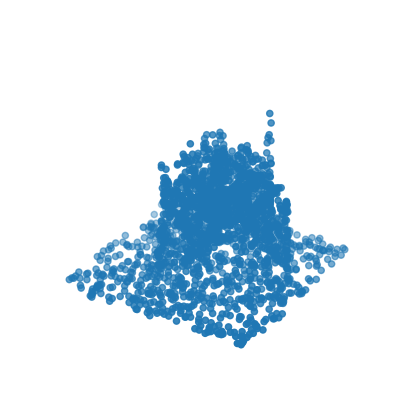

In [4]:
points = mesh.sample(2048)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

In [5]:
def parse_dataset(num_points=2048):

    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    DATA_DIR=os.getcwd()
    DATA_DIR=os.path.join(DATA_DIR,"BrainTumorOFF")
    print(DATA_DIR)
    folders = glob.glob(os.path.join(DATA_DIR, "*"))
    print(folders)
    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

In [6]:

NUM_POINTS = 2048
NUM_CLASSES = 7
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(
    NUM_POINTS
)

e:\ML\Python\pointnet-master\BrainTumorOFF
['e:\\ML\\Python\\pointnet-master\\BrainTumorOFF\\normal', 'e:\\ML\\Python\\pointnet-master\\BrainTumorOFF\\tumor']
processing class: normal
processing class: tumor


In [7]:
print(len(train_points))
print(len(train_labels))

3387
3387


In [8]:
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))



In [9]:
print(len(train_dataset))

3387


In [10]:
train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)


In [11]:
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

In [12]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

In [13]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

In [14]:
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

In [15]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(2
                       , activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2048, 3)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 2048, 32)     128         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 2048, 32)    128         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 2048, 32)     0           ['batch_normalization[0][0

In [16]:


model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=20, validation_data=test_dataset)

Epoch 1/20
106/106 [==============================] - 518s 5s/step - loss: 1.7553 - sparse_categorical_accuracy: 0.7924 - val_loss: 1.4543 - val_sparse_categorical_accuracy: 0.8987
Epoch 2/20
106/106 [==============================] - 494s 5s/step - loss: 1.4372 - sparse_categorical_accuracy: 0.8657 - val_loss: 1.2400 - val_sparse_categorical_accuracy: 0.9360
Epoch 3/20
106/106 [==============================] - 494s 5s/step - loss: 1.3587 - sparse_categorical_accuracy: 0.8875 - val_loss: 1.2839 - val_sparse_categorical_accuracy: 0.9120
Epoch 4/20
106/106 [==============================] - 493s 5s/step - loss: 1.3378 - sparse_categorical_accuracy: 0.8911 - val_loss: 1.2829 - val_sparse_categorical_accuracy: 0.9093
Epoch 5/20
106/106 [==============================] - 494s 5s/step - loss: 1.3080 - sparse_categorical_accuracy: 0.9135 - val_loss: 1.2582 - val_sparse_categorical_accuracy: 0.9467
Epoch 6/20
106/106 [==============================] - 492s 5s/step - loss: 1.3039 - sparse_cate

1/1 [==============================] - 1s 1s/step


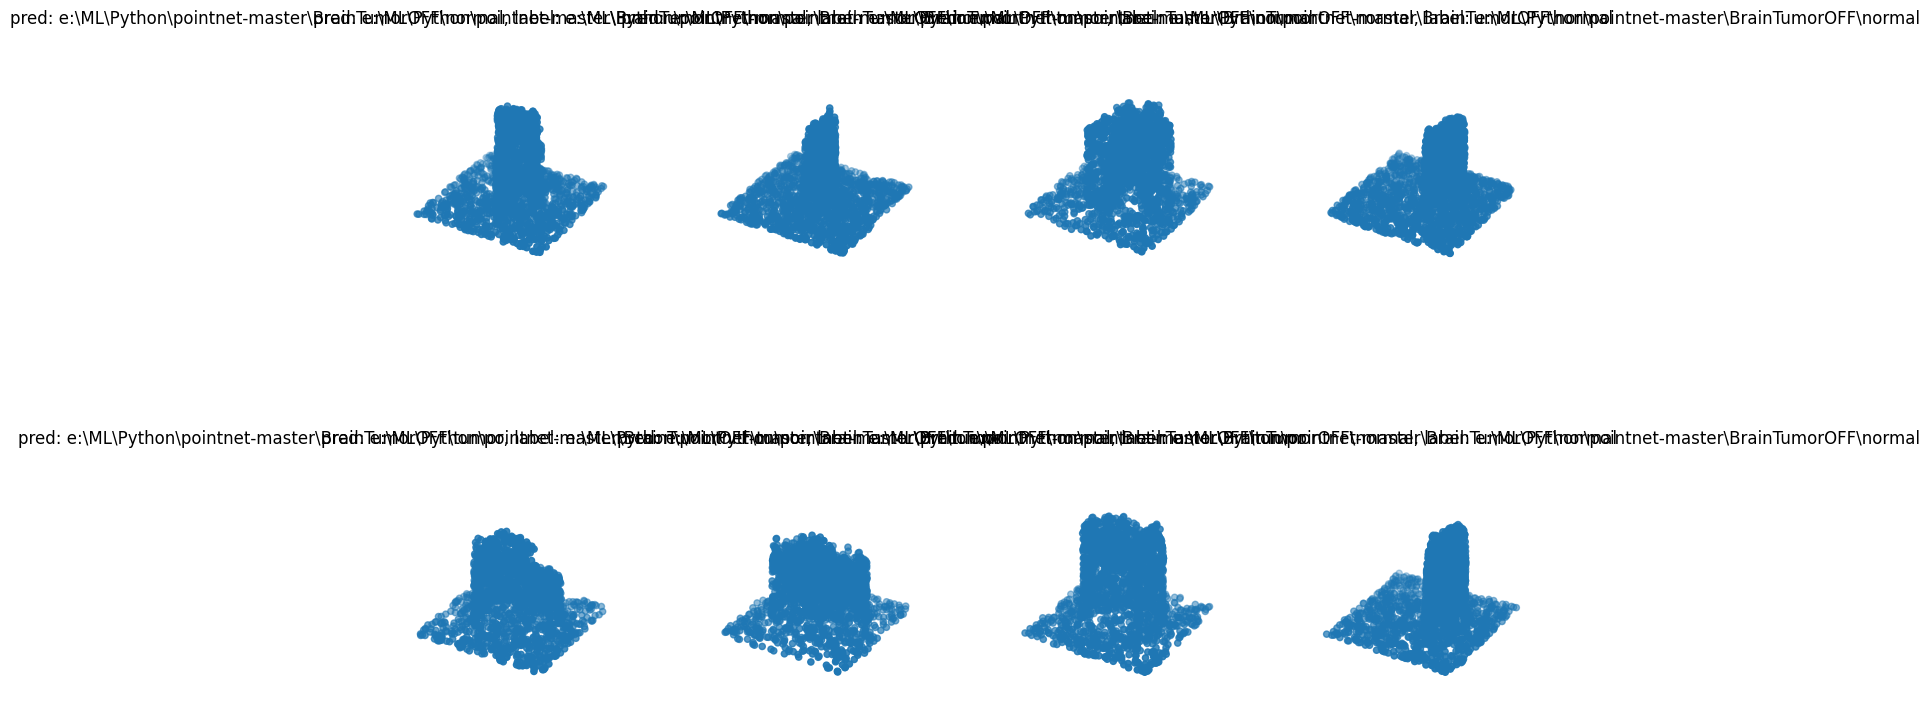

In [17]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()

12/12 [==============================] - 6s 510ms/step


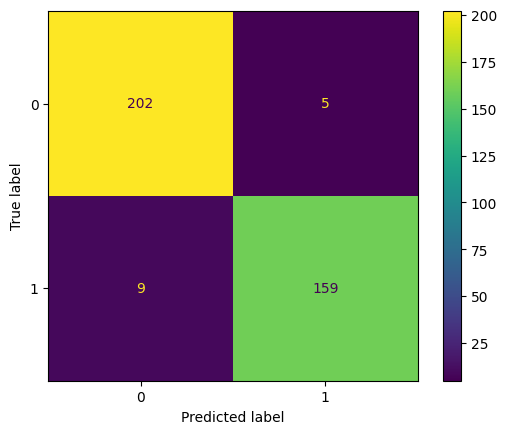

In [23]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
predic=model.predict(test_points)
predic=tf.argmax(predic,-1)
s=confusion_matrix(test_labels,predic)
disp=ConfusionMatrixDisplay(s)
disp.plot()
plt.show()

In [20]:
model.fit(train_dataset, epochs=4, validation_data=test_dataset)

Epoch 1/4
106/106 [==============================] - 490s 5s/step - loss: 1.1924 - sparse_categorical_accuracy: 0.9557 - val_loss: 1.1425 - val_sparse_categorical_accuracy: 0.9680
Epoch 2/4
106/106 [==============================] - 466s 4s/step - loss: 1.1848 - sparse_categorical_accuracy: 0.9622 - val_loss: 1.2579 - val_sparse_categorical_accuracy: 0.9467
Epoch 3/4
106/106 [==============================] - 472s 4s/step - loss: 1.1855 - sparse_categorical_accuracy: 0.9560 - val_loss: 1.1924 - val_sparse_categorical_accuracy: 0.9520
Epoch 4/4
106/106 [==============================] - 456s 4s/step - loss: 1.1605 - sparse_categorical_accuracy: 0.9658 - val_loss: 1.2305 - val_sparse_categorical_accuracy: 0.9307


In [22]:
model.fit(train_dataset, epochs=1, validation_data=test_dataset)

106/106 [==============================] - 513s 5s/step - loss: 1.1555 - sparse_categorical_accuracy: 0.9684 - val_loss: 1.1736 - val_sparse_categorical_accuracy: 0.9627
